## Importing library and loading processed data

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
nlp = spacy.load('en_core_web_sm')
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


C:\Users\Ritik\anaconda3\envs\ritik\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ritik\anaconda3\envs\ritik\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\Ritik\anaconda3\envs\ritik\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\Ritik\anaconda3\envs\ritik\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
import plotly.tools as tls
import plotly.graph_objs as go
import base64
import numpy as np
import pandas as pd

import plotly.offline as py
py.init_notebook_mode(connected=True)

%matplotlib inline


In [3]:
df = pd.read_csv(
    'D:\\Projects\\Topic modelling\\Code\\topic_modelling\\data_cleaning\\Amphan_cleaned.csv')


In [4]:
df.head()

,date,id,content,ct,year,month,quarter,week
0,31-12-2020 20:35,1.340000e+18,The year was a tough one with covid and Amphan...,tough wrecking havoc miss single care lunch,2020,12,4,53
1,31-12-2020 20:21,1.340000e+18,Pandemic.Trump impeachment. Joe Biden.Kamala H...,pandemic trump impeachment kamala harry coast ...,2020,12,4,53
2,31-12-2020 20:04,1.340000e+18,@sumonseng @ranjona @kavita_krishnan @sagarika...,sell pronunciation chauvinism rural afflict mo...,2020,12,4,53
3,31-12-2020 19:51,1.340000e+18,"Diamond Princess, Zoom calls\nAir strikes in S...",diamond princess zoom tony henry stock crash m...,2020,12,4,53
4,31-12-2020 17:42,1.340000e+18,Okay...m not going to mention anyone in partic...,mention particular type health actually forward,2020,12,4,53


In [5]:
df.shape

(41120, 8)

In [6]:
text=df.ct.values.tolist()

## Modelling

In [7]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print("="*70)


In [8]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemm = WordNetLemmatizer()

class LemmaCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))


In [9]:
tf_vectorizer = LemmaCountVectorizer(max_df=0.95,
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)


## NNMF

In [10]:
from sklearn.decomposition import NMF


In [11]:
nmf = NMF(n_components=10, solver="mu", random_state=8)

W = nmf.fit_transform(tf)


C:\Users\Ritik\anaconda3\envs\ritik\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [12]:
W

array([[7.89073407e-03, 0.00000000e+00, 4.29974947e-03, ...,
        0.00000000e+00, 4.51278423e-03, 0.00000000e+00],
       [5.97890387e-03, 6.35827019e-11, 1.91750478e-45, ...,
        1.27527595e-13, 0.00000000e+00, 1.04410103e-10],
       [1.60855776e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.54374333e-05, 0.00000000e+00],
       ...,
       [9.90665781e-03, 0.00000000e+00, 7.14227617e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.18456718e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.02273342e-02, 0.00000000e+00],
       [1.43111372e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [13]:
# params = {
#     'n_components': [10, 12, 15],
#     'learning_decay': [0.75, 0.80, 0.85]
# }

# lda_search = GridSearchCV(lda,
#                           param_grid=params,
#                           cv=3,
#                           return_train_score=False)

# lda_search.fit(tf)

# results = pd.DataFrame(lda_search.cv_results_)


## Getting our topics from the data using LDA

In [14]:
tf_feature_names = tf_vectorizer.get_feature_names()
n_top_words=30
print_top_words(nmf, tf_feature_names, n_top_words)



Topic #0:devastate situation support pandemic face fund crisis thank time vernment post minister donate fight world lose provide life hope aftermath save bad visit money raise chief work team city think

Topic #1:wind speed high afternoon cross hour extremely rain maximum near close current rainfall increase northeastward past sustain evening coast intensity morning update intense cate heavy scary tomorrow weak coastal late

Topic #2:stay pray home safety hope strong soon alert indoors scary care bad family panic city bless recover love lose coastal shall away inside tough pas dangerous follow dear terrify almighty

Topic #3:heavy rain coastal rainfall strong high flood alert lash weather surge velocity bring cause forecast witness receive gusty tomorrow warn video downpour airport region couple follow district brace watch western

Topic #4:day electricity water area power service supply work connection restore post restoration mobile road customer city phone connectivity drinking ele

## Visualising our wordcloud for topics

In [15]:
first_topic = nmf.components_[7]
first_topic_words = [tf_feature_names[i]
                     for i in first_topic.argsort()[:-50 - 1:-1]]

second_topic = nmf.components_[1]
second_topic_words = [tf_feature_names[i]
                     for i in second_topic.argsort()[:-50 - 1:-1]]

third_topic = nmf.components_[2]
third_topic_words = [tf_feature_names[i]
                     for i in third_topic.argsort()[:-50 - 1:-1]]


fourth_topic = nmf.components_[8]
fourth_topic_words = [tf_feature_names[i]
                     for i in third_topic.argsort()[:-50 - 1:-1]]


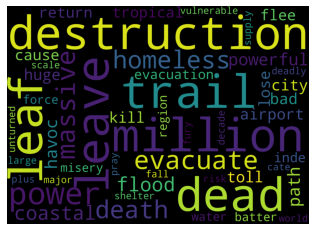

In [16]:
from wordcloud import WordCloud
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

firstcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='black',
    width=2500,
    height=1800
).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()


Here the topic is about the destruction that led to evacuation of peoples, floods, power outrages, airport suspension, etc. leaving many people homeless and in immediate requiredment of assitance
<!-- Here the talk is about the surveys done by the government,officials,teams,etc including aerial survey to check the situation of the disaster that has caused huge/extensive amount of damager that may have caused crore of rupees -->

<!-- Here the talk is about funds where the people are in need in assistance and they are questioning the govt about funds, individual organisation have come in help of people affected and even people are askked to make donation for the affected. -->

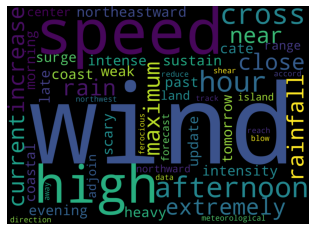

In [17]:
secondcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='black',
    width=2500,
    height=1800
).generate(" ".join(second_topic_words))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()


Here the talk is all about the extreme climatic events that have occured due to the cyclone like high wind speed,floods,rains,etc. and that has made the people alerted and they are continously updated of the situation

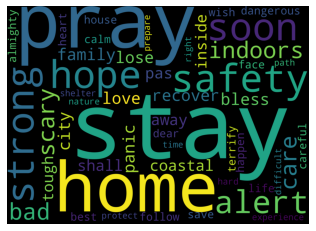

In [18]:
thirdcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='black',
    width=2500,
    height=1800
).generate(" ".join(third_topic_words))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()


The above wordcloud states the intensiveness of the cyclone that was about to struck the cast or have struck the coast.People were scared as it was a category 5 cyclone. Everyone seems to be caring about each other


## Predict topics for given sentence

In [19]:
df_topic_keywords = pd.DataFrame(nmf.components_)


In [20]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in [
                         '-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out


def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=[
                             'NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = tf_vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = nmf.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(
        topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores





In [21]:
mytext = ["Feared from cyclone"]
topic, prob_scores = predict_topic(text=mytext)


In [22]:
nmf_output = nmf.transform(tf)


## Cluster documents that share same topic and similar topics

In [23]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=10, random_state=100).fit_predict(nmf_output)

svd_model = TruncatedSVD(n_components=2)  
nmf_output_svd = svd_model.fit_transform(nmf_output)

x = nmf_output_svd[:, 0]
y = nmf_output_svd[:, 1]

print("Component's weights: \n", np.round(svd_model.components_, 2))

print("Perc of Variance Explained: \n", np.round(
    svd_model.explained_variance_ratio_, 2))


Component's weights: 
 [[ 0.33  0.35  0.41  0.34  0.34  0.25  0.37  0.28  0.15  0.26]
 [-0.25  0.64 -0.24  0.31 -0.38 -0.18  0.35 -0.21 -0.17 -0.07]]
Perc of Variance Explained: 
 [0.09 0.13]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

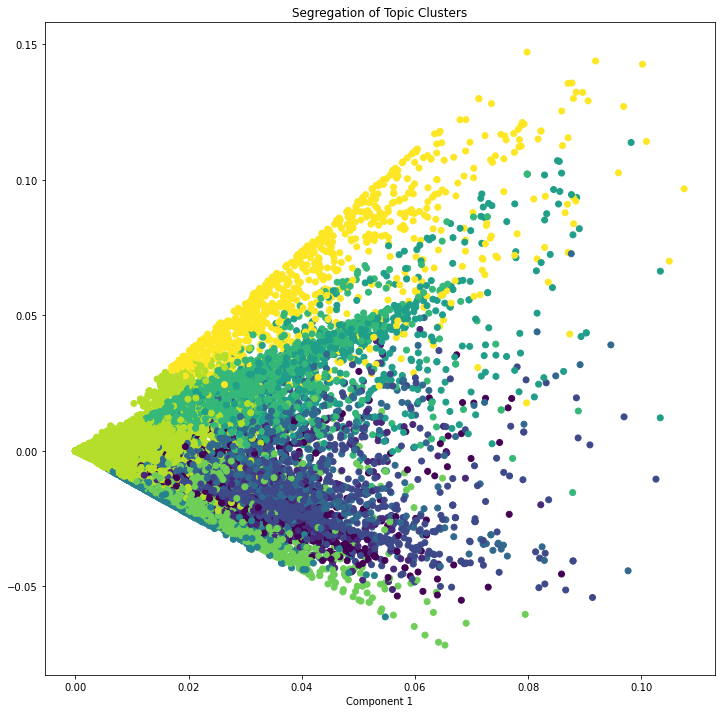

In [24]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
